## Text Translation (French to English)

## Objective

To train a neural network model that can translate French words to English words.



## Dataset Source & Acknowledgements

Kaggle Dataset: Bilingual Sentence Pairs

https://www.kaggle.com/datasets/alincijov/bilingual-sentence-pairs

https://www.kaggle.com/code/harshjain123/machine-translation-seq2seq-lstms

In [1]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector,TimeDistributed,Bidirectional,Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)
import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline

## French to English Translation

## Read in Dataset

In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("./raw_data/fra.txt")
fra_eng = to_lines(data)
fra_eng = array(fra_eng)

In [5]:
fra_eng = fra_eng[:50000,:]

## Text Preprocessing

In [6]:
# Remove punctuation
fra_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,0]]
fra_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,1]]

fra_eng

array([['Go', 'Va ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Go', 'Marche',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
       ['Go', 'Bouge ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)'],
       ...,
       ['Tom liked what he saw', 'Tom a aimé ce quil a vu',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619279 (Aiji)'],
       ['Tom liked what he saw', 'Tom aima ce quil vit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619280 (Aiji)'],
       ['Tom likes skiing too', 'Tom aussi aime skier',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2869208 (CK) & #5591397 (Aiji)']],
      dtype='<U325')

In [7]:
# convert text to lowercase
for i in range(len(fra_eng)):
    fra_eng[i,0] = fra_eng[i,0].lower()
    fra_eng[i,1] = fra_eng[i,1].lower()

In [8]:
# empty lists
eng_l = []
fra_l = []

# populate the lists with sentence lengths
for i in fra_eng[:,0]:
      eng_l.append(len(i.split()))

for i in fra_eng[:,1]:
      fra_l.append(len(i.split()))

## Text Tokenization

In [9]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(fra_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6042


In [11]:
# prepare french tokenizer
fra_tokenizer = tokenization(fra_eng[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1

fra_length = 8
print('French Vocabulary Size: %d' % fra_vocab_size)

French Vocabulary Size: 13974


In [12]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

## Modelling

In [13]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(fra_eng, test_size=0.2, random_state = 12)

In [14]:
# prepare training data
X_train = encode_sequences(fra_tokenizer, fra_length, train[:, 1])
y_train = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
X_test = encode_sequences(fra_tokenizer, fra_length, test[:, 1])
y_test = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [15]:
# build model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(Bidirectional(LSTM(units)))
    model.add(RepeatVector(out_timesteps))
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model

In [16]:
# model compilation
model = define_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 512)

In [17]:
rms = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
# use EarlyStopping in the case when val_accuracy reaches a plateau (not improving much)
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=10, 
    min_delta = 0.001)

# create model checkpoint callback to save the best model checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best_checkpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Train the model

In [19]:
# train model
history = model.fit(X_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[es, model_checkpoint_callback], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 140s 2s/step - loss: 3.7397 - accuracy: 0.5544 - val_loss: 2.8377 - val_accuracy: 0.5683
Epoch 2/30
63/63 [==============================] - 129s 2s/step - loss: 2.7658 - accuracy: 0.5754 - val_loss: 2.7288 - val_accuracy: 0.5859
Epoch 3/30
63/63 [==============================] - 132s 2s/step - loss: 2.5609 - accuracy: 0.6017 - val_loss: 2.4819 - val_accuracy: 0.6141
Epoch 4/30
63/63 [==============================] - 133s 2s/step - loss: 2.3001 - accuracy: 0.6325 - val_loss: 2.2701 - val_accuracy: 0.6469
Epoch 5/30
63/63 [==============================] - 132s 2s/step - loss: 2.0521 - accuracy: 0.6606 - val_loss: 2.0798 - val_accuracy: 0.6708
Epoch 6/30
63/63 [==============================] - 132s 2s/step - loss: 1.8255 - accuracy: 0.6851 - val_loss: 1.9367 - val_accuracy: 0.6842
Epoch 7/30
63/63 [==============================] - 131s 2s/step - loss: 1.6376 - accuracy: 0.7026 - val_loss: 1.8359 - val_accuracy: 0.6970
Epoch 8/30
63

## Model Evaluation

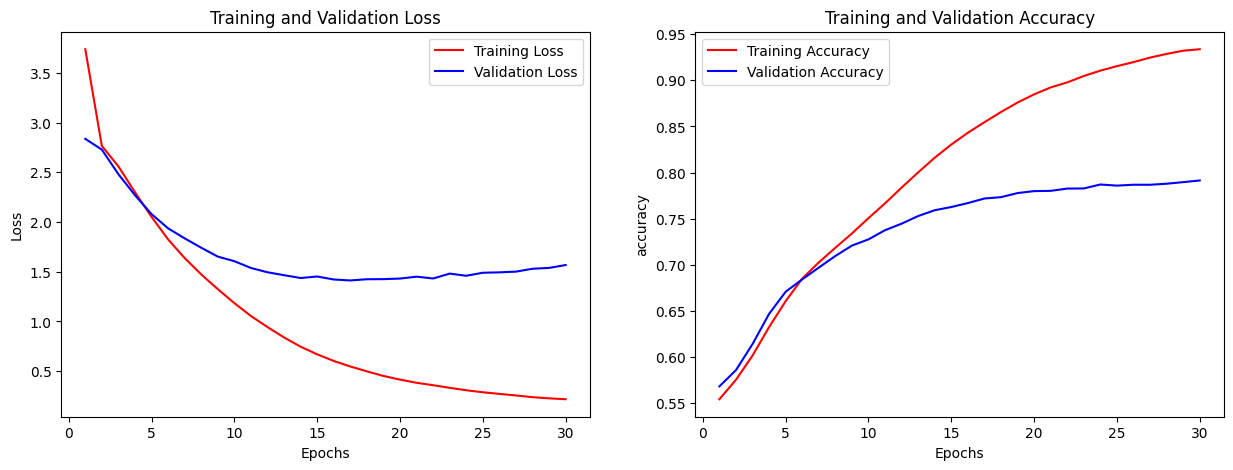

In [20]:
fig, (p1, p2) = plt.subplots(1, 2, figsize=(15,5))

x = range(1, 31)

p1.plot(x, history.history['loss'], 'r', label='Training Loss')
p1.plot(x, history.history['val_loss'], 'b', label='Validation Loss')
p1.set_title('Training and Validation Loss')
p1.set_xlabel('Epochs')
p1.set_ylabel('Loss')
p1.legend()

p2.plot(x, history.history['accuracy'], 'r', label='Training Accuracy')
p2.plot(x, history.history['val_accuracy'], 'b', label='Validation Accuracy')
p2.set_title('Training and Validation Accuracy')
p2.set_xlabel('Epochs')
p2.set_ylabel('accuracy')
p2.legend()

plt.show()

In [22]:
import pickle

with open("./output/model.pkl", "wb") as file_obj:
    pickle.dump(model, file_obj)

## Text Translation Prediction

In [23]:
preds = np.argmax(model.predict(X_test), axis=-1)

313/313 [==============================] - 31s 91ms/step


In [24]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word

In [25]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [26]:
pred_fra2eng = pd.DataFrame({'actual_fra' : test[:,1], 'actual_eng' : test[:,0], 'predicted_eng' : preds_text})

In [27]:
# print rows
pred_fra2eng

,actual_fra,actual_eng,predicted_eng
0,je suis contente de lentendre,im glad to hear it,im glad to hear it
1,cest mort,its dead,its
2,ne tarrête pas de grimper,keep climbing,keep climbing
3,je vous respecte,i respect you,ill will you
4,quest ce que tu as fait ensuite,what did you do then,what you
...,...,...,...
9995,la leçon deux est facile,lesson two is easy,he is are
9996,il neige làbas,its snowing there,its snowing there
9997,continuez à creuser,continue digging,keep digging
9998,je pense que vous avez raison,i think youre right,i think youre right


In [33]:
# print rows
pred_fra2eng.head(10)

,actual_fra,actual_eng,predicted_eng
0,je suis contente de lentendre,im glad to hear it,im glad to hear it
1,cest mort,its dead,its
2,ne tarrête pas de grimper,keep climbing,keep climbing
3,je vous respecte,i respect you,ill will you
4,quest ce que tu as fait ensuite,what did you do then,what you
5,je vous donnerai un indice,ill give you a hint,ill give you a hint
6,sontelles déjà arrivées,have they arrived yet,have they just come
7,elle sait tout,she knows everything,she knows everything
8,jespère que cest vrai,i hope its true,i hope its true
9,ils mont dépouillée,they robbed me blind,they robbed me blind


## End of Notebook